# Libraries needed

In [2]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

2022-08-11 16:04:30,010 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/sg7549/tmp/dask-worker-space/worker-qk2y037q', purging
2022-08-11 16:04:30,011 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/sg7549/tmp/dask-worker-space/worker-wphosmi9', purging
2022-08-11 16:04:30,012 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/sg7549/tmp/dask-worker-space/worker-79ov1x34', purging
2022-08-11 16:04:30,013 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/sg7549/tmp/dask-worker-space/worker-8jcjigtp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34567,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:38733,Total threads: 1
Dashboard: /proxy/34789/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:37643,


# Monthly averaged data

In [2]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [3]:
# These are the directory names, concatonated on the path above
variables = ['2t', 'mtpr', '10u', '10v', 'msdrswrf', 'aluvp']

- Open concatenated datasets:

In [4]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')
data['sns'] = (1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']
data['wind'] = np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: 10u
Opened
Opening: 10v
Opened
Opening: msdrswrf
Opened
Opening: aluvp
Opened


- Extract the locations of interest and put them in a dataarray:

In [5]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

- Get nearest point in ERA5 for all variables (removing u10 and v10 from the list because we don't want them):

In [ ]:
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'index', 'time'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

- Replace negative values in rainfall with 0

In [ ]:
extracted_data['mtpr'] = xr.where(old_ncfile['mtpr']<0, 0, old_ncfile['mtpr'])

- Add land mask.
For this, we open a variable that we know is masked. In this case, wind.
Open just one file, we don't care about time variations

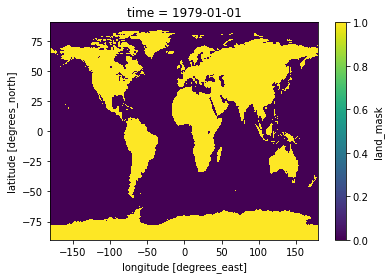

In [9]:

mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/wind/1979/wind_era5_moda_sfc_19790101-19790131.nc')['wind']
mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [ ]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['land_mask'] = xr.DataArray(ext, 
                                           dims = {'index'}, 
                                           coords = {'index':extracted_data['index']})

In [11]:
# write out the data
# This data DOESN'T have Tmax, Tmin, or RH. Go to last section in this notebook for that.
extracted_data.to_netcdf('ERA5-monthly_averaged.nc')

# Daily averaged data

In [3]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

- Load the required Lat & Long coordinates
- Resample the data from hourly to daily

In [26]:
def preprocessing(ds):
    # Preprocess to extract everything above 70S
    #ds = ds.sel(latitude = slice(90, -70), longitude = slice(-156, 156))
    ds = ds.sel(time = slice('2005-01-01', '2020-01-01'), longitude = slice(112, 156), latitude = slice(-7, -44))
    # Resample to daily via averaging
    ds = ds.resample(time = '1D').mean('time')
    #ds = ds.resample(time = '1D').mean('time', keepdims=True)
    return ds

In [4]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [5]:
#variables = ['mtpr', 'mn2t', 'mx2t', '10fg']
variables = ['mtpr']

- Open the datasets and apply the preprocessing function

In [15]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/20*/*.nc'))
    data[v] = xr.open_mfdataset(listv, chunks = {'time': -1})
    print('Opened')

Opening: mtpr
Opened


In [27]:
ds = preprocessing(data['mtpr'])

In [28]:
ds

<xarray.Dataset>
Dimensions:    (time: 5479, longitude: 177, latitude: 149)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2020-01-01
  * longitude  (longitude) float32 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0
  * latitude   (latitude) float32 -7.0 -7.25 -7.5 -7.75 ... -43.5 -43.75 -44.0
Data variables:
    mtpr       (time, latitude, longitude) float32 dask.array<chunksize=(1, 149, 177), meta=np.ndarray>

In [17]:
data['mtpr']

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 195744)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2022-04-30T23:00:00
Data variables:
    mtpr       (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-07 10:06:24 UTC+1100 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis mean_total_precipitation_rate...

In [12]:
extracted_data.to_netcdf('ERA5-daily_averaged_mtpr.nc')